In [1]:
# Libraries
import numpy as np
from matplotlib import pyplot as plt
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix",
      "font.size": 14}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
import pymc3 as pm
import seaborn as sns
from functools import reduce
import theano
import theano.tensor as tt
from scipy.integrate import quad

import arviz as az
import pandas as pd
import subprocess # for calling leakiest

import time

## Sklearn mutual info implementation
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif, SelectKBest


## Scipy entropy/kl-divergence
from scipy.stats import entropy, randint

## Auxiliary functions
def mi_analytical(jm):
    res=0
    py = [sum([jm[x][j] for x in range(len(jm))]) for j in range(len(jm[0]))]
    px = 1/len(jm) # it is uniform
    for i in range(len(jm)):
        for j in range(len(jm[0])):
#             py = sum([jm[x][j] for x in range(len(jm))])
#             px = 1/len(jm) # it is uniform
            res=res+((jm[i][j]*np.log2(jm[i][j]/(px*py[j]))) if jm[i][j] > 0 else 0)
    return res

def trace_mi_analytical(t,s_domain,o_domain):
    res=0
    py=[np.mean(t['output']==j) for j in range(o_domain)]
    for i in range(s_domain):
        px=np.mean(t['secret']==i)
        for j in range(o_domain):
            pxy=np.mean((t['secret']==i) & (t['output']==j))            
            res=res+((pxy*np.log2(pxy/(px*py[j]))) if pxy > 0 else 0)
    return res

## Bayes vulnerability is just the sum of the maximums for each output of the joint distribution (Theorem 5.15, page 83, QIF book)
def bayes_vul(jm):
    res=0
    for j in range(len(jm[0])):        
        res = res + max([jm[x][j] for x in range(len(jm))])
    return res

def trace_bayes_vul(t,s_domain,o_domain):
    res=0
    for j in range(o_domain):        
        res = res + max([np.mean((t['secret']==i) & (t['output']==j)) for i in range(s_domain)])
    return res

## Estimated channel matrix from the trace
def estimated_jm(trace,s_domain,o_domain):    
    jm = [ [ 0 for j in range(o_domain) ] for i in range(s_domain) ]
    for i in range(s_domain):
        for j in range(o_domain):
            jm[i][j]=np.mean((trace['secret']==i) & (trace['output']==j))
    return jm

## Custom mi sklearn function
def mi_sklearn(t_secret,t_output,disc_features,n_neigh):    
    mi_nat = mutual_info_regression(t_secret.reshape(-1,1), t_output, 
                                     discrete_features=disc_features,n_neighbors=n_neigh)
    return mi_nat[0]/np.log(2)
#[1,2,3].reshape(-1,1)=[[1],[2],[3]]

print("Running on PyMC3 v{}".format(pm.__version__))


############################
## MI analytical solution ##
############################
# Analytical solution (only for adding two numbers model)
def gen_jm(num_secrets):
    num_outputs = (num_secrets*2)-1
    x = list(range(num_secrets))
    jm = [ [ 0 for i in range(num_outputs) ] for j in range(num_secrets) ]
    for i in range(num_secrets):
        for j in range(num_secrets):
            jm[i][i+j]=1/(num_secrets**2)
    return jm

###################
## FBLEAU plugin ##
###################
import re
def fbleau_bayes_risk(t):
    #Creating datasets
    df=pd.DataFrame(zip(t['secret'],t['output']),columns=['s','o'])
    tr=int(0.8*len(df))
    df_train=df.iloc[:tr]
    df_test=df.iloc[tr:]
    df_test = df_test.drop(df_test[~df_test['s'].isin(df_train['s'])].index)
    
    # Save datasets as csv
    train_data='fbleau_train.csv'
    test_data='fbleau_test.csv'
    df.to_csv('fbleau.csv',header=False,index=False)
    df_train.to_csv(train_data,header=False,index=False)
    df_test.to_csv(test_data,header=False,index=False)
    
    # Execute fbleau
    fbleau_exec='~/.cargo/bin/fbleau'
    cmd=fbleau_exec+' knn --knn-strategy ln '+train_data+' '+test_data
    stdout=subprocess.check_output(cmd, shell=True, text=True)
    
    # Print output
#     print(stdout)
    return float(re.search('Minimum estimate: (.*)\nMul',stdout).group(1))

#####################
## LeakiEst plugin ##
#####################
def leakiest_mi(t):
    xs=["("+str(x) for x in t['secret']]
    ys=[str(x)+")" for x in t['output']]
    leakiest_data='leakiest.csv'
    pd.Series(ys,xs).to_csv(leakiest_data,header=False)

    leakiest_dir='~/programs/leakiest-1.4.9/'    
    cmd='java -jar '+leakiest_dir+'leakiest-1.4.9.jar -mi -di -o '+leakiest_data+' -v 0'
    stdout=subprocess.check_output(cmd, shell=True, text=True)
#     print(stdout)
    return float(re.search('Estimated mutual information: (.*) \(out',stdout).group(1))


# P(X+Y = x) with X~U(0,n) and Y~U(0,m) -> https://math.stackexchange.com/questions/3016719/sum-of-two-discrete-uniform-random-variables
def sum_disc_uniforms(z,n,m):
    return sum([randint.pmf(i,0,n)*randint.pmf(z-i,0,m) for i in range(0,n)])


def sum_discN_uniforms(z,n,num_vars):
    if num_vars==2:
        # P(X+Y=z) = \sum_i=0^n P(X=i)*P(Y=z-i)
        return np.array([randint.pmf(i,0,n)*randint.pmf(z-i,0,n) for i in range(0,n)]).sum()
    else:
        # P(X_0+X_1+...+Y=z) = \sum_i=0^{n*num_vars+1} P(X_0+X_1+... = z)P(Y=z-i)
        return np.array([sum_discN_uniforms(i,n,num_vars-1)*randint.pmf(z-i,0,n) for i in range(0,(n*num_vars)+1)]).sum()
    
LEAKWATCH_TRACES_DIR='leakwatch-traces/'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.2


In [2]:
# Model: Adding up two numbers
# s + x_0 + ... + x_N = o
## parameters
# rv_type : {'continuous', 'discrete'}. Experiment type
# num_secrets : int. Size of secret domain
# N : int. Number of variables in the problem
def create_model(rv_type,num_secrets,N,sigma=1):
    
    ## Create a discrete model
    if rv_type == "discrete":        
        with pm.Model() as model_discrete:
            secret = pm.DiscreteUniform("secret",lower=0,upper=num_secrets-1)
            others = pm.DiscreteUniform("others",lower=0,upper=num_secrets-1,shape=N)
            output = pm.Deterministic("output",(secret+others.sum()))
            return model_discrete
    
    ## Create a continuous model
    elif rv_type == "continuous":        
        with pm.Model() as model_continuous:
            secret = pm.Normal("secret",mu=42,sigma=sigma)
            others = pm.Normal("others",mu=55,sigma=1,shape=N)
            output = pm.Deterministic("output",(secret+others.sum())/(N+1))
            return model_continuous

    ## Error in the random varible type
    print('incorrent rv type')
    return -1

## Discrete 

### $s + x_0 = o$ with $x_i \sim U(0,\texttt{num_secrets})$ and $\texttt{num_secrets} = 100$

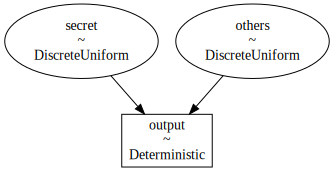

In [3]:
## Setup
N           = 1
num_secrets = 100
rv_type     = "discrete"
m1=create_model(rv_type,num_secrets,N)
pm.model_to_graphviz(m1)

In [4]:
num_samples=100000
with m1:
    trace=pm.sample(num_samples,chains=1,tune=5000)

<ipython-input-4-c34ded5c4207>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(num_samples,chains=1,tune=5000)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [others]
>Metropolis: [secret]


Sampling 1 chain for 5_000 tune and 100_000 draw iterations (5_000 + 100_000 draws total) took 18 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (100000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


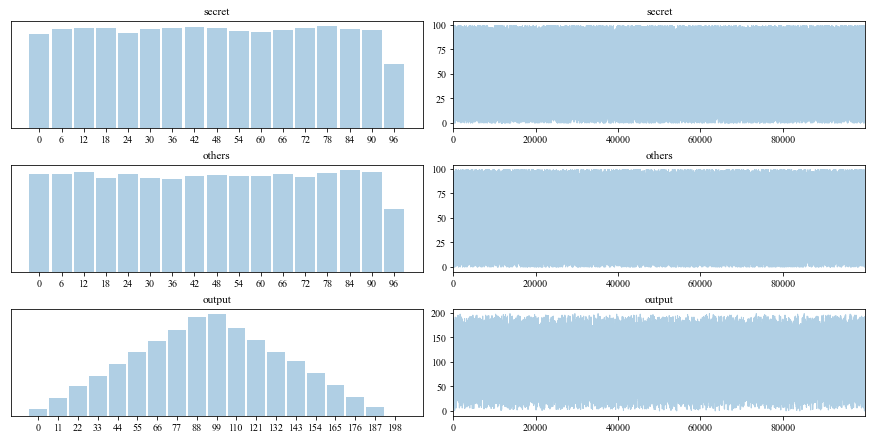

In [5]:
pm.plot_trace(az.from_pymc3(trace,model=m1))
plt.show()

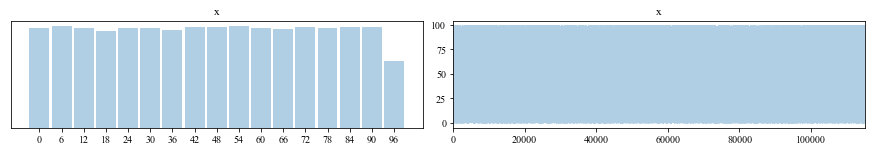

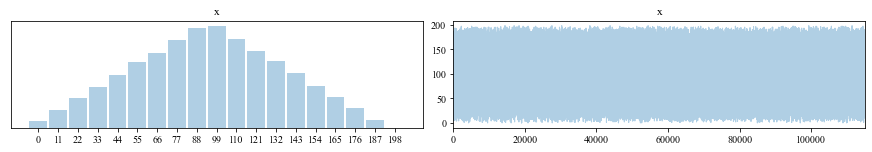

In [6]:
df=pd.read_csv(LEAKWATCH_TRACES_DIR+'data-sum-secureprng-100.csv')
trace_secret_leakwatch=df['secret'].to_numpy()
trace_output_leakwatch=df['output'].to_numpy()

pm.plot_trace(trace_secret_leakwatch)
plt.show()
pm.plot_trace(trace_output_leakwatch)
plt.show()

#### Probability Query

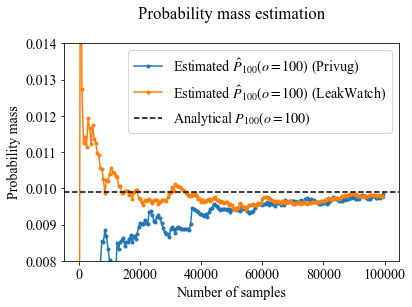

In [7]:
outcome=100
samples_to_test=num_samples

x=np.arange(100, samples_to_test, 500)
y=[np.mean(trace[-i:]['output']==outcome) for i in x]
y_leakwatch=[np.mean(trace_output_leakwatch[-i:]==outcome) for i in x]
plt.plot(x,y,marker='.',label='Estimated $\hat{P}_{'+str(num_secrets)+'}(o='+str(outcome)+')$ (Privug)')
plt.plot(x,y_leakwatch,marker='.',label='Estimated $\hat{P}_{'+str(num_secrets)+'}(o='+str(outcome)+')$ (LeakWatch)')
plt.axhline(y=sum_disc_uniforms(outcome,num_secrets,num_secrets),
            linestyle='--', color='black',  
            label='Analytical $P_{'+str(num_secrets)+'}(o='+str(outcome)+')$')
plt.ylim((0.008,0.014))
plt.legend(loc='best')
plt.ylabel('Probability mass')
plt.xlabel('Number of samples')
plt.title('Probability mass estimation\n')
plt.show()

#### Mutual Information

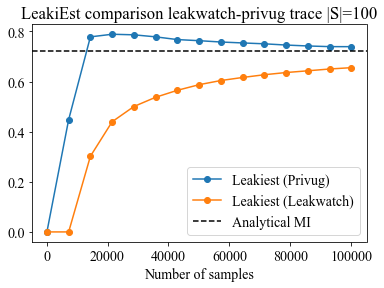

In [8]:
samples_to_test=num_samples

x=np.linspace(100,samples_to_test,15,dtype=int)
jm=gen_jm(num_secrets)
yleakiest=[leakiest_mi(trace[-i:]) for i in x]
yleakiestleakwatch=[leakiest_mi(df[-i:]) for i in x]
plt.plot(x,yleakiest, label='Leakiest (Privug)',marker='o')
plt.plot(x,yleakiestleakwatch, label='Leakiest (Leakwatch)',marker='o')
plt.axhline(y=mi_analytical(jm),
            linestyle='--', color='black',  label='Analytical MI')
plt.legend(loc='best')
plt.title('LeakiEst comparison leakwatch-privug trace |S|='+str(num_secrets))
plt.xlabel('Number of samples')
plt.show()

#### Bayes Risk

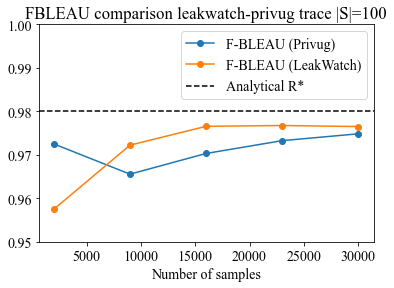

In [9]:
samples_to_test=30000
x=np.linspace(2000,samples_to_test,5,dtype=int)
yfbleau=[fbleau_bayes_risk(trace[-i:]) for i in x]
yfbleauleakwatch=[fbleau_bayes_risk(df[-i:]) for i in x]
plt.plot(x,yfbleau,marker='o',label='F-BLEAU (Privug)')
plt.plot(x,yfbleauleakwatch,marker='o',label='F-BLEAU (LeakWatch)')
plt.ylim((0.95,1))
plt.axhline(y=1-bayes_vul(jm),
            linestyle='--', color='black',
            label='Analytical R*')
plt.legend(loc='best')
plt.title('FBLEAU comparison leakwatch-privug trace |S|='+str(num_secrets))
plt.xlabel('Number of samples')
plt.show()

### $s + x_0 = o$ with $x_i \sim U(0,\texttt{num_secrets})$ and $\texttt{num_secrets} = 500$

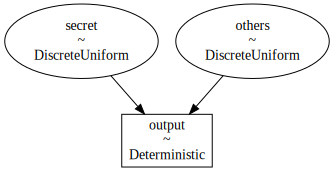

In [10]:
## Setup
N           = 1
num_secrets = 500
rv_type     = "discrete"
m1=create_model(rv_type,num_secrets,N)
pm.model_to_graphviz(m1)

In [11]:
num_samples=1000000
with m1:
    trace=pm.sample(num_samples,chains=1,tune=5000)

<ipython-input-11-d76e3eddd087>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(num_samples,chains=1,tune=5000)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [others]
>Metropolis: [secret]


Sampling 1 chain for 5_000 tune and 1_000_000 draw iterations (5_000 + 1_000_000 draws total) took 169 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


<ipython-input-12-426fb4ca0212>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(az.from_pymc3(trace,model=m1))


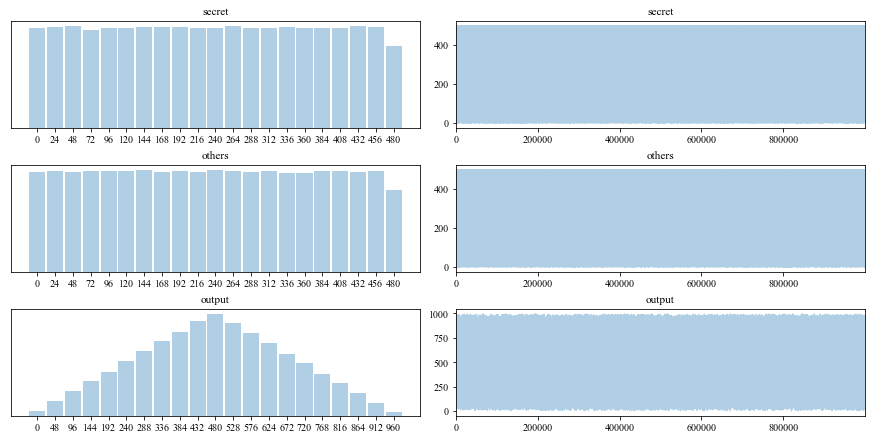

In [12]:
pm.traceplot(az.from_pymc3(trace,model=m1))
plt.show()

Leakwatch execution time: 3 min 16 sec. to generate 1000000 samples


<ipython-input-13-975524a667ee>:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_secret_leakwatch)


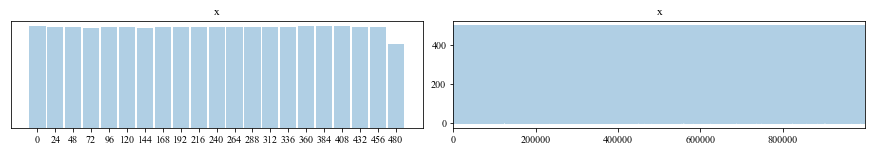

<ipython-input-13-975524a667ee>:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_output_leakwatch)


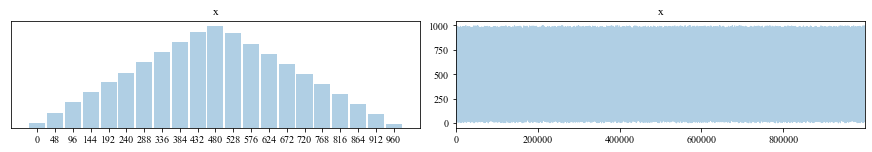

In [13]:
df=pd.read_csv(LEAKWATCH_TRACES_DIR+'data-sum2-500-1000000.csv')
print('Leakwatch execution time: 3 min 16 sec. to generate 1000000 samples')
trace_secret_leakwatch=df['secret'].to_numpy()
trace_output_leakwatch=df['output'].to_numpy()

pm.traceplot(trace_secret_leakwatch)
plt.show()
pm.traceplot(trace_output_leakwatch)
plt.show()

#### Probability Query

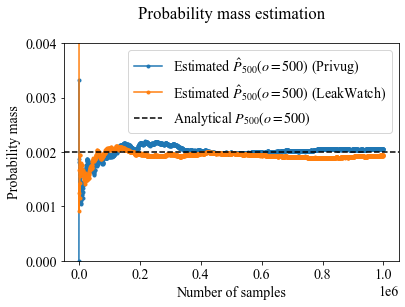

In [14]:
outcome=500
samples_to_test=num_samples

x=np.arange(100, samples_to_test, 500)
y=[np.mean(trace[-i:]['output']==outcome) for i in x]
y_leakwatch=[np.mean(trace_output_leakwatch[-i:]==outcome) for i in x]
plt.plot(x,y,marker='.',label='Estimated $\hat{P}_{'+str(num_secrets)+'}(o='+str(outcome)+')$ (Privug)')
plt.plot(x,y_leakwatch,marker='.',label='Estimated $\hat{P}_{'+str(num_secrets)+'}(o='+str(outcome)+')$ (LeakWatch)')
plt.axhline(y=sum_disc_uniforms(outcome,num_secrets,num_secrets),
            linestyle='--', color='black',  
            label='Analytical $P_{'+str(num_secrets)+'}(o='+str(outcome)+')$')
plt.ylim((0,0.004))
plt.legend(loc='best')
plt.ylabel('Probability mass')
plt.xlabel('Number of samples')
plt.title('Probability mass estimation\n')
plt.show()

#### Mutual Information

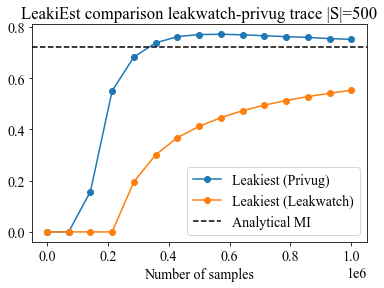

In [15]:
samples_to_test=num_samples

x=np.linspace(100,samples_to_test,15,dtype=int)
jm=gen_jm(num_secrets)
yleakiest=[leakiest_mi(trace[-i:]) for i in x]
yleakiestleakwatch=[leakiest_mi(df[-i:]) for i in x]
plt.plot(x,yleakiest, label='Leakiest (Privug)',marker='o')
plt.plot(x,yleakiestleakwatch, label='Leakiest (Leakwatch)',marker='o')
plt.axhline(y=mi_analytical(jm),
            linestyle='--', color='black',  label='Analytical MI')
plt.legend(loc='best')
plt.title('LeakiEst comparison leakwatch-privug trace |S|='+str(num_secrets))
plt.xlabel('Number of samples')
plt.show()

#### Bayes Risk

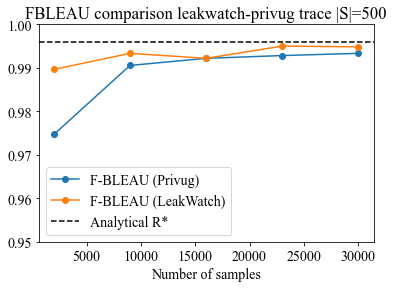

In [16]:
samples_to_test=30000
x=np.linspace(2000,samples_to_test,5,dtype=int)
jm=gen_jm(num_secrets)
yfbleau=[fbleau_bayes_risk(trace[-i:]) for i in x]
yfbleauleakwatch=[fbleau_bayes_risk(df[-i:]) for i in x]
plt.plot(x,yfbleau,marker='o',label='F-BLEAU (Privug)')
plt.plot(x,yfbleauleakwatch,marker='o',label='F-BLEAU (LeakWatch)')
plt.ylim((0.95,1))
plt.axhline(y=1-bayes_vul(jm),
            linestyle='--', color='black',
            label='Analytical R*')
plt.legend(loc='best')
plt.title('FBLEAU comparison leakwatch-privug trace |S|='+str(num_secrets))
plt.xlabel('Number of samples')
plt.show()

### $s + x_0 = o$ with $x_i \sim U(0,\texttt{num_secrets})$ and $\texttt{num_secrets} = 1000$

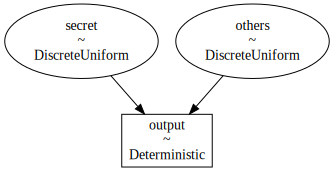

In [17]:
## Setup
N           = 1
num_secrets = 1000
rv_type     = "discrete"
m1=create_model(rv_type,num_secrets,N)
pm.model_to_graphviz(m1)

In [18]:
num_samples=1000000
with m1:
    trace=pm.sample(num_samples,chains=1,tune=5000)

<ipython-input-18-d76e3eddd087>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(num_samples,chains=1,tune=5000)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [others]
>Metropolis: [secret]


Sampling 1 chain for 5_000 tune and 1_000_000 draw iterations (5_000 + 1_000_000 draws total) took 175 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


<ipython-input-19-426fb4ca0212>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(az.from_pymc3(trace,model=m1))


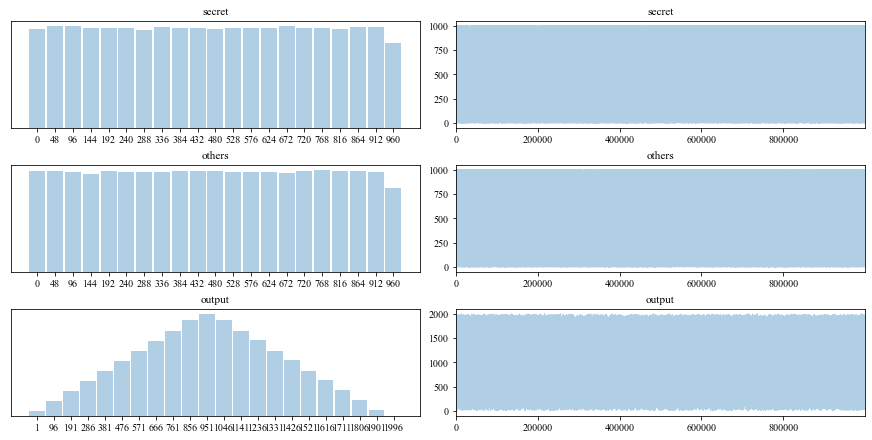

In [19]:
pm.traceplot(az.from_pymc3(trace,model=m1))
plt.show()

Leakwatch execution time: 3 min 21 sec. to generate 1000000 samples


<ipython-input-20-91be5fdcb155>:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_secret_leakwatch)


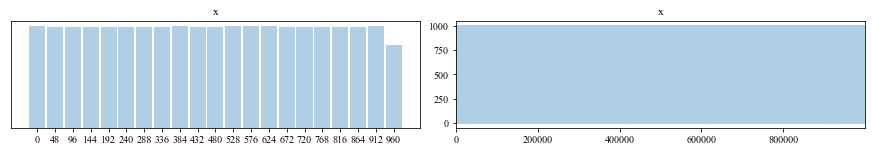

<ipython-input-20-91be5fdcb155>:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_output_leakwatch)


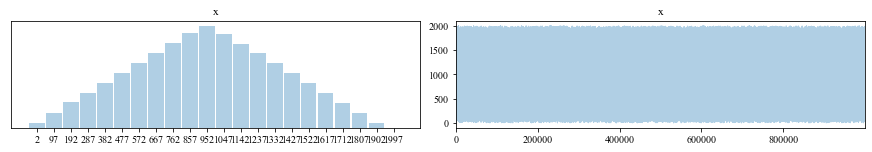

In [20]:
df=pd.read_csv(LEAKWATCH_TRACES_DIR+'data-sum2-secureprng-1000-1000000samples.csv')
print('Leakwatch execution time: 3 min 21 sec. to generate 1000000 samples')
trace_secret_leakwatch=df['secret'].to_numpy()
trace_output_leakwatch=df['output'].to_numpy()

pm.traceplot(trace_secret_leakwatch)
plt.show()
pm.traceplot(trace_output_leakwatch)
plt.show()

#### Probability Query

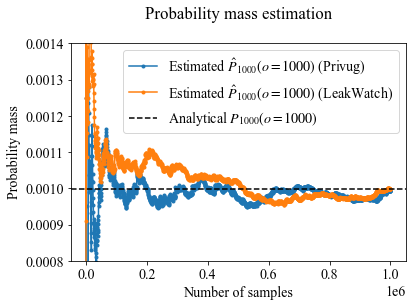

In [21]:
outcome=1000
samples_to_test=num_samples

x=np.arange(100, samples_to_test, 500)
y=[np.mean(trace[:i]['output']==outcome) for i in x]
y_leakwatch=[np.mean(trace_output_leakwatch[:i]==outcome) for i in x]
plt.plot(x,y,marker='.',label='Estimated $\hat{P}_{'+str(num_secrets)+'}(o='+str(outcome)+')$ (Privug)')
plt.plot(x,y_leakwatch,marker='.',label='Estimated $\hat{P}_{'+str(num_secrets)+'}(o='+str(outcome)+')$ (LeakWatch)')
plt.axhline(y=sum_disc_uniforms(outcome,num_secrets,num_secrets),
            linestyle='--', color='black',  
            label='Analytical $P_{'+str(num_secrets)+'}(o='+str(outcome)+')$')
plt.ylim((0.0008,0.0014))
plt.legend(loc='best')
plt.ylabel('Probability mass')
plt.xlabel('Number of samples')
plt.title('Probability mass estimation\n')
plt.show()

#### Mutual Information

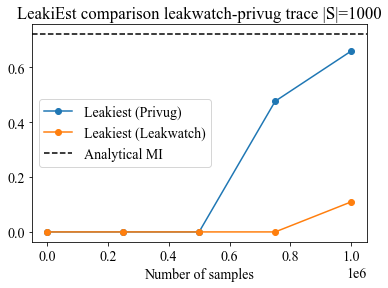

In [22]:
samples_to_test=num_samples

x=np.linspace(100,samples_to_test,5,dtype=int)
jm=gen_jm(num_secrets)
yleakiest=[leakiest_mi(trace[-i:]) for i in x]
yleakiestleakwatch=[leakiest_mi(df[-i:]) for i in x]
plt.plot(x,yleakiest, label='Leakiest (Privug)',marker='o')
plt.plot(x,yleakiestleakwatch, label='Leakiest (Leakwatch)',marker='o')
plt.axhline(y=mi_analytical(jm),
            linestyle='--', color='black',  label='Analytical MI')
plt.legend(loc='best')
plt.title('LeakiEst comparison leakwatch-privug trace |S|='+str(num_secrets))
plt.xlabel('Number of samples')
plt.savefig('leakiest-privug-mi-N='+str(N)+'-'+str(num_secrets)+'.pdf')
plt.show()

#### Bayes Risk

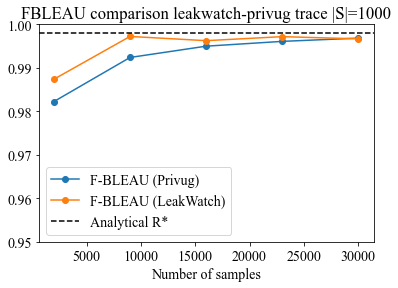

In [23]:
samples_to_test=30000
x=np.linspace(2000,samples_to_test,5,dtype=int)
jm=gen_jm(num_secrets)
yfbleau=[fbleau_bayes_risk(trace[-i:]) for i in x]
yfbleauleakwatch=[fbleau_bayes_risk(df[-i:]) for i in x]
plt.plot(x,yfbleau,marker='o',label='F-BLEAU (Privug)')
plt.plot(x,yfbleauleakwatch,marker='o',label='F-BLEAU (LeakWatch)')
plt.ylim((0.95,1))
plt.axhline(y=1-bayes_vul(jm),
            linestyle='--', color='black',
            label='Analytical R*')
plt.legend(loc='best')
plt.title('FBLEAU comparison leakwatch-privug trace |S|='+str(num_secrets))
plt.xlabel('Number of samples')
plt.savefig('fbleau-privug-r*-'+str(N)+'-'+str(num_secrets)+'.pdf')
plt.show()

### $s + x_0 = o$ with $x_i \sim U(0,\texttt{num_secrets})$ and $\texttt{num_secrets} = 10000$

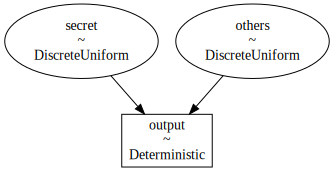

In [24]:
## Setup
N           = 1
num_secrets = 10000
rv_type     = "discrete"
m1=create_model(rv_type,num_secrets,N)
pm.model_to_graphviz(m1)

In [25]:
num_samples=1000000
with m1:
    trace=pm.sample(num_samples,chains=1,tune=5000)

<ipython-input-25-d76e3eddd087>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(num_samples,chains=1,tune=5000)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [others]
>Metropolis: [secret]


Sampling 1 chain for 5_000 tune and 1_000_000 draw iterations (5_000 + 1_000_000 draws total) took 202 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (1000000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Leakwatch execution time: 3 min 12 sec. to generate 1000000 samples


<ipython-input-26-d6763050593c>:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_secret_leakwatch)


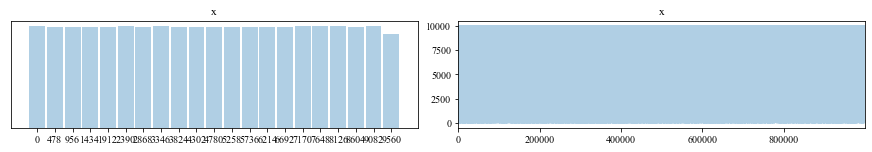

<ipython-input-26-d6763050593c>:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_output_leakwatch)


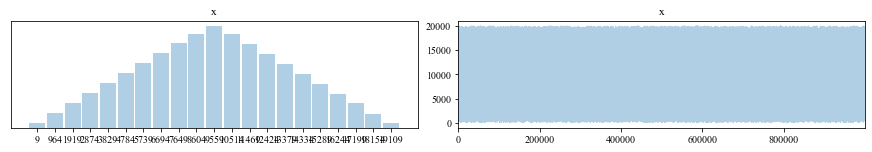

In [26]:
df=pd.read_csv(LEAKWATCH_TRACES_DIR+'data-sum2-10000-1000000.csv')
print('Leakwatch execution time: 3 min 12 sec. to generate 1000000 samples')
trace_secret_leakwatch=df['secret'].to_numpy()
trace_output_leakwatch=df['output'].to_numpy()

pm.traceplot(trace_secret_leakwatch)
plt.show()
pm.traceplot(trace_output_leakwatch)
plt.show()

#### Probability Query

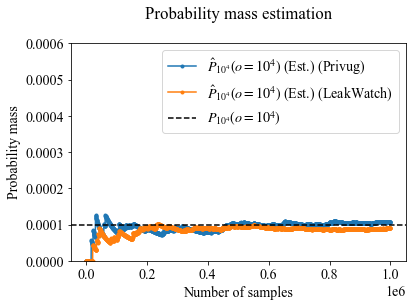

In [27]:
outcome=10000
samples_to_test=num_samples
analytical_solution=sum_disc_uniforms(outcome,num_secrets,num_secrets)
x=np.arange(100, samples_to_test, 500)
y=[np.mean(trace[:i]['output']==outcome) for i in x]
y_leakwatch=[np.mean(trace_output_leakwatch[:i]==outcome) for i in x]
plt.plot(x,y,marker='.',label='$\hat{P}_{10^4}(o=10^4)$ (Est.) (Privug)')
plt.plot(x,y_leakwatch,marker='.',label='$\hat{P}_{10^4}(o=10^4)$ (Est.) (LeakWatch)')
plt.axhline(y=analytical_solution,
            linestyle='--', color='black',  
            label='$P_{10^4}(o=10^4)$')
plt.ylim((0,0.0006))
plt.legend(loc='best')
plt.ylabel('Probability mass')
plt.xlabel('Number of samples')
plt.title('Probability mass estimation\n')
plt.savefig('probability_query_add_'+str(N)+'_uniform_'+str(num_secrets)+'.pdf',bbox_inches='tight')
plt.show()

## Continuous

### $s + x_0/2 = o$ with $s \sim N(\mu=42,\sigma=8), x_i \sim N(\mu=55,\sigma=1)$

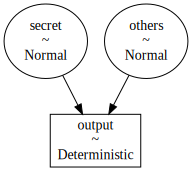

In [28]:
## Setup
N           = 1
sigma       = 8
rv_type     = "continuous"
m1=create_model(rv_type,0,N,sigma=sigma)
pm.model_to_graphviz(m1)

In [29]:
num_samples=100000
with m1:
    trace=pm.sample(num_samples,chains=1,tune=5000,target_accept=0.9)

<ipython-input-29-4d63cf6b4fbf>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(num_samples,chains=1,tune=5000,target_accept=0.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [others, secret]


Sampling 1 chain for 5_000 tune and 100_000 draw iterations (5_000 + 100_000 draws total) took 59 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


<ipython-input-30-426fb4ca0212>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(az.from_pymc3(trace,model=m1))


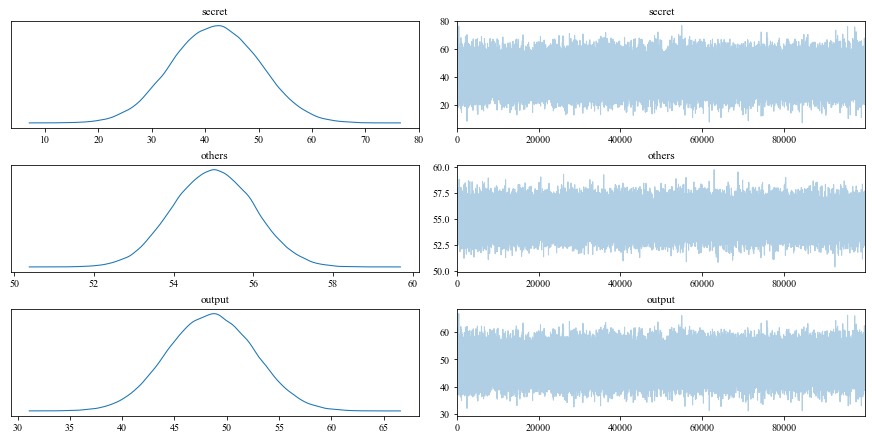

In [30]:
pm.traceplot(az.from_pymc3(trace,model=m1))
plt.show()

Leakwatch execution time 0 min 22 sec for generating 100000 samples


<ipython-input-31-712bc3ffb8f9>:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_secret_leakwatch)


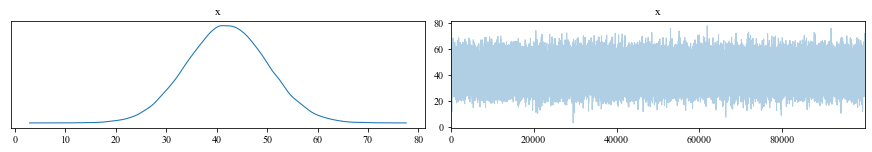

<ipython-input-31-712bc3ffb8f9>:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_output_leakwatch)


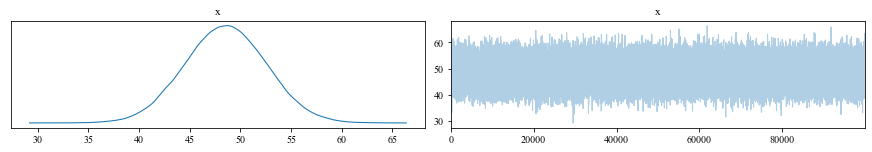

In [31]:
df=pd.read_csv(LEAKWATCH_TRACES_DIR+'data-gaussians2avg.csv')
print("Leakwatch execution time 0 min 22 sec for generating 100000 samples")
trace_secret_leakwatch=df['secret'].to_numpy()
trace_output_leakwatch=df['output'].to_numpy()

pm.traceplot(trace_secret_leakwatch)
plt.show()
pm.traceplot(trace_output_leakwatch)
plt.show()

#### Probability Query

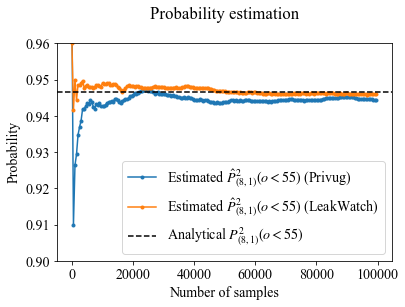

In [32]:
from scipy.stats import norm
outcome=55
samples_to_test=100000

x=np.arange(100, samples_to_test, 500)
y=[np.mean(trace[-i:]['output']<outcome) for i in x]
y_leakwatch=[np.mean(trace_output_leakwatch[:i]<outcome) for i in x]
plt.plot(x,y,marker='.',label='Estimated $\hat{P}^2_{('+str(sigma)+',1)}(o<'+str(outcome)+')$ (Privug)')
plt.plot(x,y_leakwatch,marker='.',label='Estimated $\hat{P}^2_{('+str(sigma)+',1)}(o<'+str(outcome)+')$ (LeakWatch)')
plt.axhline(y=norm.cdf(outcome,loc=(55+42)/2,scale=np.sqrt((64+1)/4)),
            linestyle='--', color='black',  
            label='Analytical $P^2_{('+str(sigma)+',1)}(o<'+str(outcome)+')$')
plt.ylim((0.9,0.96))
plt.legend(loc='best')
plt.ylabel('Probability')
plt.xlabel('Number of samples')
plt.title('Probability estimation\n')
plt.show()

#### Mutual Information

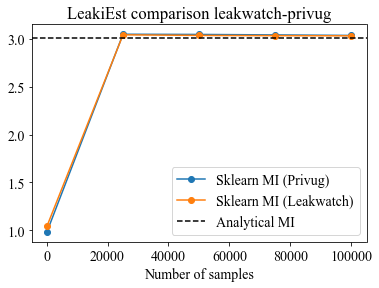

In [33]:
samples_to_test=100000
n_neigh=40

x=np.linspace(100,samples_to_test,5,dtype=int)
yleakiest=[mi_sklearn(trace['secret'][-i:],trace['output'][-i:],disc_features=False,n_neigh=n_neigh) for i in x]
yleakiestleakwatch=[mi_sklearn(df[-i:]['secret'].to_numpy(),df[-i:]['output'].to_numpy(),disc_features=False,n_neigh=n_neigh) for i in x]
plt.plot(x,yleakiest, label='Sklearn MI (Privug)',marker='o')
plt.plot(x,yleakiestleakwatch, label='Sklearn MI (Leakwatch)',marker='o')
plt.axhline(y=(0.5*np.log2(1+(64/N))),
            linestyle='--', color='black',  label='Analytical MI')
plt.legend(loc='best')
plt.title('LeakiEst comparison leakwatch-privug')
plt.xlabel('Number of samples')
plt.savefig('leakiest-privug-mi-normal-mu0-sigma'+str(sigma)+'.pdf')
plt.show()

### $s + x_0 + \ldots + x_{199}/201 = o$ with $s \sim N(\mu=0,\sigma=8) ,x_i \sim N(\mu=0,\sigma=1)$

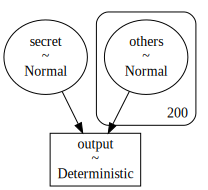

In [34]:
## Setup
N           = 200
sigma       = 8
rv_type     = "continuous"
m1=create_model(rv_type,0,N,sigma=sigma)
pm.model_to_graphviz(m1)

In [35]:
num_samples=20000
with m1:
    trace=pm.sample(num_samples,chains=1,tune=5000)

<ipython-input-35-c8e25b716f89>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace=pm.sample(num_samples,chains=1,tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [others, secret]


Sampling 1 chain for 5_000 tune and 20_000 draw iterations (5_000 + 20_000 draws total) took 25 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


<ipython-input-36-426fb4ca0212>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(az.from_pymc3(trace,model=m1))


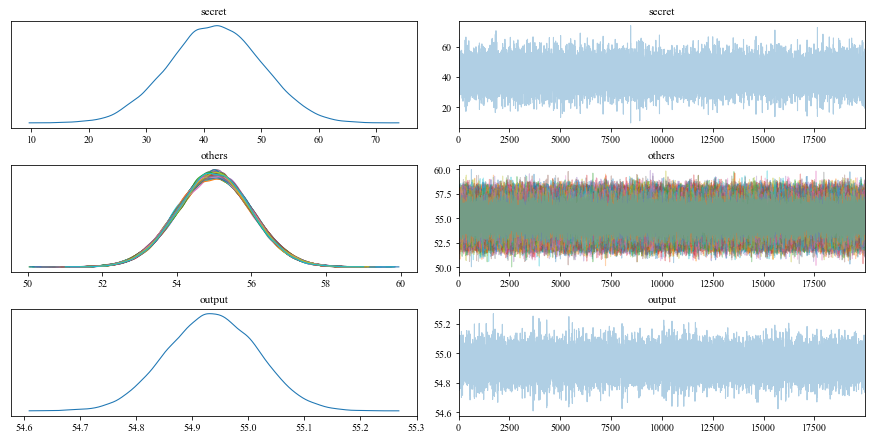

In [36]:
pm.traceplot(az.from_pymc3(trace,model=m1))
plt.show()

Leakwatch execution time 4 min 37 sec for generating 100000 samples


<ipython-input-37-44b0121583b9>:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_secret_leakwatch)


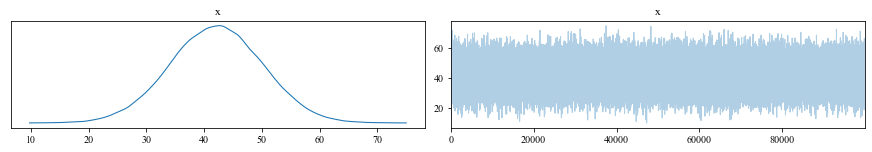

<ipython-input-37-44b0121583b9>:8: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace_output_leakwatch)


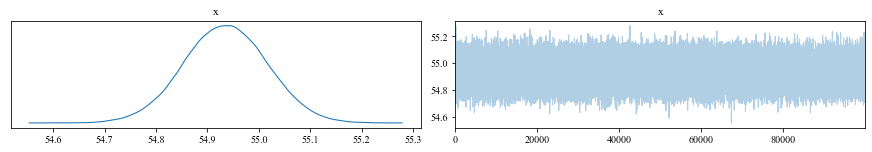

In [37]:
df=pd.read_csv(LEAKWATCH_TRACES_DIR+'data-gaussiansNavg.csv')
print("Leakwatch execution time 4 min 37 sec for generating 100000 samples")
trace_secret_leakwatch=df['secret'].to_numpy()
trace_output_leakwatch=df['output'].to_numpy()

pm.traceplot(trace_secret_leakwatch)
plt.show()
pm.traceplot(trace_output_leakwatch)
plt.show()

#### Probability Query

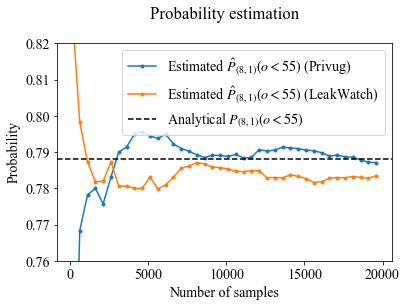

In [38]:
from scipy.stats import norm
outcome=55
samples_to_test=num_samples

x=np.arange(100, samples_to_test, 500)
y=[np.mean(trace[-i:]['output']<outcome) for i in x]
y_leakwatch=[np.mean(trace_output_leakwatch[:i]<outcome) for i in x]
plt.plot(x,y,marker='.',label='Estimated $\hat{P}_{('+str(sigma)+',1)}(o<'+str(outcome)+')$ (Privug)')
plt.plot(x,y_leakwatch,marker='.',label='Estimated $\hat{P}_{('+str(sigma)+',1)}(o<'+str(outcome)+')$ (LeakWatch)')
plt.axhline(y=norm.cdf(outcome,loc=(55*N+42)/(N+1),scale=np.sqrt((64+N)/(N+1)**2)),
            linestyle='--', color='black',
            label='Analytical $P_{('+str(sigma)+',1)}(o<'+str(outcome)+')$')
plt.ylim((0.76,0.82))
plt.legend(loc='best')
plt.ylabel('Probability')
plt.xlabel('Number of samples')
plt.title('Probability estimation\n')
plt.show()

#### Mutual Information

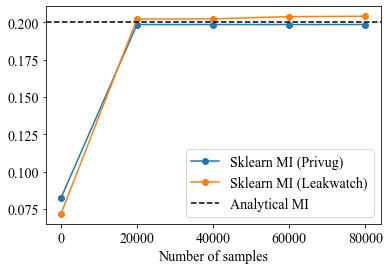

In [39]:
samples_to_test=80000
n_neigh=20

x=np.linspace(100,samples_to_test,5,dtype=int)
yleakiest=[mi_sklearn(trace['secret'][-i:],trace['output'][-i:],disc_features=False,n_neigh=n_neigh) for i in x]
yleakiestleakwatch=[mi_sklearn(df[-i:]['secret'].to_numpy(),df[-i:]['output'].to_numpy(),disc_features=False,n_neigh=n_neigh) for i in x]
plt.plot(x,yleakiest, label='Sklearn MI (Privug)',marker='o')
plt.plot(x,yleakiestleakwatch, label='Sklearn MI (Leakwatch)',marker='o')
plt.axhline(y=(0.5*np.log2(1+(64/N))),
            linestyle='--', color='black',  label='Analytical MI')
plt.legend(loc='best')
plt.xlabel('Number of samples')
plt.show()

## Running time

The data below is computed by running the continuous version of the program with the corresponding number of variables. That is, setting `N` to the correpsonding number of variables. As for Leakwatch we run the program `GaussianN.java`.

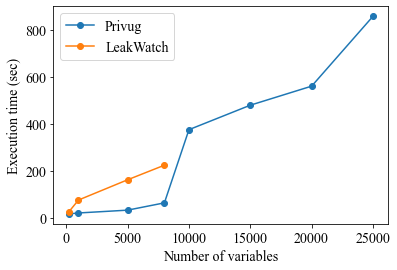

In [40]:
# leakwatch crashes with an error when saving traces of 10000 variables. After it has generated 11000 samples.
# leakwatch crashes with an error when saving traces of 5000 variables. After it has generated 23000 samples.
# leakwatch crashes with an error when saving traces of 2000 variables. After it has generated 67000 samples.

x_leakwatch = [200,1000,5000,8000]
y_leakwatch = [25,1*60+16,2*60+42,3*60+44]
x_privug    = [200,1000,5000,8000,10000,15000,20000,25000]
y_privug    = [17, 21, 33, 1*60+4, 6*60+15, 7*60+59,9*60+20,14*60+17]

plt.plot(x_privug,y_privug, label='Privug', marker='o')
plt.plot(x_leakwatch,y_leakwatch, label='LeakWatch', marker='o')
plt.legend(loc='best')
plt.ylabel('Execution time (sec)')
plt.xlabel('Number of variables')
plt.savefig('running-time-privug-leakwatch.pdf')

## Complexity

In [41]:
# Benchamark to test O(n^c)
@theano.compile.ops.as_op(itypes=[tt.lscalar, tt.lscalar],otypes=[tt.lscalar])
def f_pymc3(n,c):
    arr=np.arange(0,n)
    return f_aux(arr,c)

def f(n,c):
    arr=np.arange(0,n)
    return f_aux(arr,c)

def f_aux(arr,c):
    if c==1:
        return sum([i for i in arr])
    else:
        return sum([f_aux(arr,c-1) for i in arr])
    
def f_loops_aux(arr,c):
    if c==1:
        res=0
        for i in arr:
            res+=i
        return res
    else:
        res=0
        for i in arr:
            res+=f_loops_aux(arr,c-1)
        return res
    
def timed_f(n,c):
    t_init=time.time()
    f(n,c)
    return time.time()-t_init

def time_sampling(n,c):
    t_init=time.time()
    with pm.Model() as model:
        c=pm.Constant('c',c)
        n=pm.Constant('n',n)
        pm.Deterministic('f',f_pymc3(n,c))
        pm.sample(10000,chains=1)
    return time.time()-t_init

### $O(n)$ with $n \in \{100,\ldots,100000\}$

In [42]:
num_data_points=5
ns=np.linspace(100,100000,num_data_points,dtype=int)

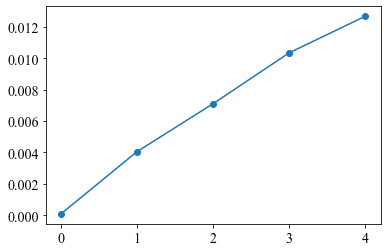

In [43]:
temp_n=np.array([[timed_f(i,1) for i in ns] for i in range(0,20)])
normal_execution_times_n=[np.mean(temp_n[:,i]) for i in range(0,5)]
plt.plot(normal_execution_times_n,marker='o')

In [44]:
pymc3_times_n=[time_sampling(i,1) for i in ns]

<ipython-input-41-03068de3873a>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  pm.sample(10000,chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 3 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (10000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks
<ipython-input-41-03068de3873a>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  pm.sample(10000,chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 40 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 74 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 108 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 149 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


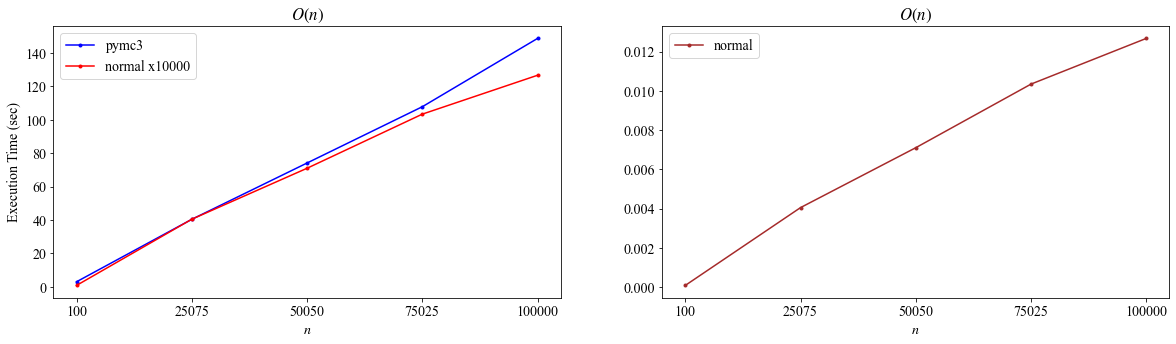

In [45]:
fig,axs=plt.subplots(1,2,figsize=(20,5))
axs[0].plot(pymc3_times_n,label='pymc3',color='blue',marker='.')
axs[0].plot([i*10000 for i in normal_execution_times_n],label='normal x10000',color='red',marker='.')
axs[0].set_xlabel('$n$')
axs[0].set_xticks(np.arange(num_data_points))
axs[0].set_xticklabels(ns)
axs[0].set_ylabel('Execution Time (sec)')
axs[0].set_title('$O(n)$')
axs[0].legend(loc='best')


axs[1].plot(normal_execution_times_n,label='normal',color='brown',marker='.')
axs[1].set_xticks(np.arange(num_data_points))
axs[1].set_xticklabels(ns)
axs[1].set_xlabel('$n$')
axs[1].set_title('$O(n)$')
axs[1].legend(loc='best')

plt.show()

### $O(20^{c})$ with $c \in \{1,2,3,4\}$

In [46]:
num_data_points=4 # starting from 1
cs=np.arange(1,num_data_points+1)

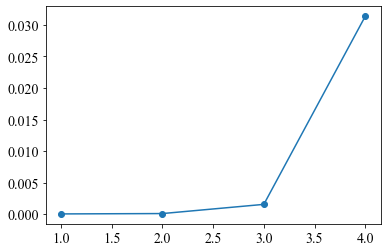

In [47]:
temp=np.array([[timed_f(20,i) for i in cs] for i in range(0,10)])
normal_execution_times_c=[np.mean(temp[:,i]) for i in range(0,num_data_points)]
plt.plot(cs,normal_execution_times_c,marker='o');

In [48]:
pymc3_times_c=[time_sampling(20,i) for i in cs]

<ipython-input-41-03068de3873a>:40: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  pm.sample(10000,chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 3 seconds.
/home/pardo/.local/lib/python3.8/site-packages/arviz/data/base.py:169: UserWarning: More chains (10000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 23 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [n]
>Metropolis: [c]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 370 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


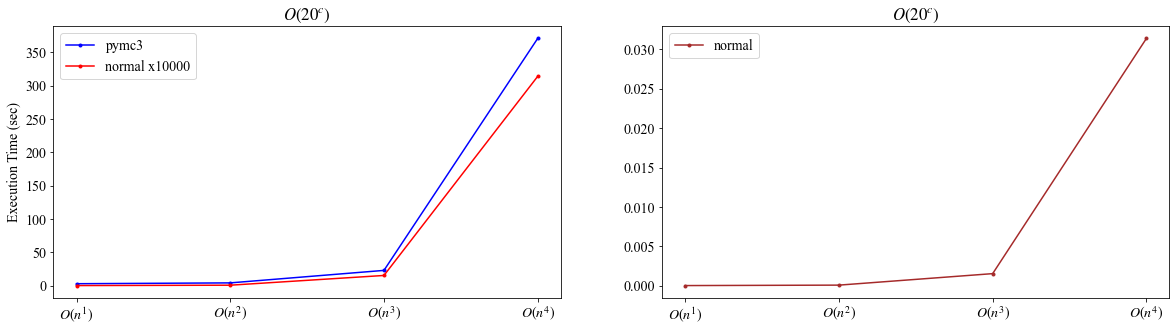

In [49]:
fig,axs=plt.subplots(1,2,figsize=(20,5))
axs[0].plot(pymc3_times_c,label='pymc3',color='blue',marker='.')
axs[0].plot([i*10000 for i in normal_execution_times_c],label='normal x10000',color='red',marker='.')
axs[0].set_xticks(np.arange(num_data_points))
axs[0].set_xticklabels(['$O(n^'+str(i)+')$' for i in cs])
axs[0].set_ylabel('Execution Time (sec)')
axs[0].set_title('$O(20^c)$')
axs[0].legend(loc='best')


axs[1].plot(normal_execution_times_c,label='normal',color='brown',marker='.')
axs[1].set_xticks(np.arange(num_data_points))
axs[1].set_xticklabels(['$O(n^'+str(i)+')$' for i in cs])
axs[1].set_title('$O(20^c)$')
axs[1].legend(loc='best')

plt.show()